In [1]:
import os
import glob
from pathlib import Path
from ftplib import FTP
from joblib import Parallel, delayed

import re

import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import zscore

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

import warnings

# Suppress ConvergenceWarning from MiniBatchKMeans
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Suppress FutureWarning for downcasting
pd.set_option('future.no_silent_downcasting', True)

#### License
```
# Copyright (c) 2025 Dietmar Rieder
#
# This source code is licensed under the BSD 3-Clause license found in the
# LICENSE file in the root directory of this source tree.
```

## Settings

#### Define input data file, annotation granularity and number of neighborhoods

In [2]:
# Define input data path
input_data_dir = Path("./data")
imc_data_file = Path(input_data_dir ,"IMC_data_aggregated_crc_atlas.csv")

# cell type column from imc_data to use
# we use lumped granularity of cell phenotype annotation
cell_type_col = 'cname_lumped' 

# Number of nearest neighbors to find
n_neighbors = 10 

# Number of Cellular Neighborhoods to discover
CN_n = 10 

# Number of CPUs to use in parallel processing
n_cpus = 4 

#### Download IMC data

In [3]:
# FTP server details
HOST = "ftp.ebi.ac.uk"
USER = "anonymous"
PASSWORD = ""

# Connect and login
ftp = FTP(HOST)
ftp.login(USER, PASSWORD)

# go to remote data directory
ftp.cwd("pub/databases/biostudies/S-BIAD/208/S-BIAD2208/Files/")

# List of files to download
files_to_download = [
    "IMC/IMC_data_aggregated_crc_atlas.csv",
]

# Create data folder
os.makedirs(input_data_dir,  mode=0o750, exist_ok=True)

# Helper function to do FTP download with progress bar
def download_(ftp, remote_path, local_path):
    size = ftp.size(remote_path)

    if not local_filename.exists() or os.path.getsize(local_path) != size:
        print(f"Downloading data file: {local_path}")
        with open(local_path, "wb") as f, tqdm(
            total=size, unit="B", unit_scale=True, desc=os.path.basename(local_path)
        ) as pbar:
            def callback(data):
                f.write(data)
                pbar.update(len(data))
            ftp.retrbinary(f"RETR {remote_path}", callback)
    else:
        print(f"Nothing to do: data file {local_path} already exits!")


for file in files_to_download:
    local_filename = Path(input_data_dir, file.split("/")[-1])
    download_(ftp, file, local_filename)

# Close connection
ftp.quit()

IMC_data_aggregated_crc_atlas.csv: 100%|██████████| 222M/222M [00:24<00:00, 8.96MB/s]   


'221 Goodbye.'

#### Define result output folder

In [4]:
# Define output directory
output_dir = Path("./results/")
os.makedirs(output_dir, mode=0o750, exist_ok=True)

### Load the IMC data

In [5]:
# Load IMC data
imc_data = pd.read_csv(imc_data_file)

### Helper functions

In [6]:
# --- Helper function for validating the input data ---
def _validate_input_df(df: pd.DataFrame,
                        cell_type_col: str = 'phenotype'
                       ) -> None:
    """
    Validates the presence of required columns in the input DataFrame.
    """
    required_cols = ['Cell_id', 'Image_id', cell_type_col, 'Location_Center_X', 'Location_Center_Y']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Input DataFrame must contain all of the following columns: {required_cols}")
    if df.empty:
        raise ValueError("Input DataFrame is empty.")

In [7]:
# --- Helper function for parallel processing single cells ---
def _generate_neighborhood_vector_single_cell(
    cell_idx: int,
    indices_array: np.ndarray,
    df_phenotypes: pd.Series,
    unique_phenotypes: list,
    phenotype_to_index: dict,
    n_neighbors: int
) -> np.ndarray:
    """
    Helper function to generate a phenotype frequency vector for a single cell's neighborhood.
    Can be used with joblib.Parallel.

    Args:
        cell_idx (int): The index of the current cell in the original DataFrame.
        indices_array (np.ndarray): Array of global indices of nearest neighbors for all cells.
        df_phenotypes (pd.Series): Series of phenotypes from the original DataFrame.
        unique_phenotypes (list): List of all unique phenotype names.
        phenotype_to_index (dict): Mapping from phenotype name to its index in the vector.
        n_neighbors (int): Number of neighbors in the window.

    Returns:
        np.ndarray: A vector representing the phenotype composition of the neighborhood.
    """
    # indices_array[cell_idx] directly provides the global indices of neighbors for this cell
    neighbor_global_indices = indices_array[cell_idx]
    neighbor_phenotypes = df_phenotypes.iloc[neighbor_global_indices]

    phenotype_counts = neighbor_phenotypes.value_counts()
    current_vector = np.zeros(len(unique_phenotypes))

    for pheno, count in phenotype_counts.items():
        if pheno in phenotype_to_index:
            current_vector[phenotype_to_index[pheno]] = count

    return current_vector

In [8]:
# --- Helper function for finding nearest neighbors ---
def _find_image_wise_neighbors(df: pd.DataFrame, n_neighbors: int) -> np.ndarray:
    """
    Finds N nearest neighbors for each cell, restricted to cells within the same image.
    Returns an array of global indices for the neighbors of each cell.
    The NearestNeighbors `n_neighbors` parameter includes the query point itself.
    """
    print(f"Finding {n_neighbors} nearest neighbors for each cell (image-wise), including self...")
    all_global_neighbor_indices = np.zeros((len(df), n_neighbors), dtype=int)

    for image_id, image_df in df.groupby('Image_id'):
        image_coords = image_df[['Location_Center_X', 'Location_Center_Y']].values
        original_global_indices_for_image = image_df.index.values

        if len(image_coords) == 0:
            print(f"Warning: Image '{image_id}' has no cells. Skipping NearestNeighbors calculation.")
            continue
        
        # Get NN of cell in image
        nn_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')
        nn_model.fit(image_coords)
        _, image_local_indices = nn_model.kneighbors(image_coords)

        for i, original_cell_idx_in_df in enumerate(original_global_indices_for_image):
            all_global_neighbor_indices[original_cell_idx_in_df] = original_global_indices_for_image[image_local_indices[i]]

    print("Image-wise NearestNeighbors calculation complete.")
    return all_global_neighbor_indices

In [9]:
# --- Helper function for generating phenotype frequency vectors ---
def _generate_neighborhood_vectors(
    df: pd.DataFrame, 
    indices_array: np.ndarray,
    n_neighbors: int,
    n_jobs: int,
    cell_type_col: str = 'phenotype'
) -> tuple[np.ndarray, list]:
    """
    Generates phenotype frequency vectors for all cellular neighborhoods using parallel processing.
    """
    print(f"Creating neighborhood windows and phenotype frequency vectors (using {n_jobs} cores)...")

    unique_phenotypes = sorted(df[cell_type_col].unique().tolist())
    phenotype_to_index = {pheno: i for i, pheno in enumerate(unique_phenotypes)}
    df_phenotypes_series = df[cell_type_col]

    # Handle empty DataFrame gracefully
    if df.empty:
        print("Input DataFrame is empty, returning empty neighborhood vectors.")
        return np.array([]).reshape(0, len(unique_phenotypes)), unique_phenotypes

    neighborhood_vectors_list = Parallel(n_jobs=n_jobs)(
        delayed(_generate_neighborhood_vector_single_cell)(
            i, indices_array, df_phenotypes_series, unique_phenotypes, phenotype_to_index, n_neighbors
        ) for i in range(len(df))
    )

    neighborhood_vectors = np.array(neighborhood_vectors_list)

    print(f"Generated {len(neighborhood_vectors)} neighborhood vectors, each of length {len(unique_phenotypes)}.")
    return neighborhood_vectors, unique_phenotypes

In [10]:
# --- Helper function for clustering neighborhood vectors ---
def _cluster_neighborhood_vectors(
    neighborhood_vectors: np.ndarray, n_clusters: int, random_state: int
) -> np.ndarray:
    """Clusters the neighborhood frequency vectors using MiniBatchKMeans."""
    print(f"Clustering neighborhood vectors using MiniBatchKMeans with k={n_clusters}...")
    if neighborhood_vectors.shape[0] == 0:
        print("No neighborhood vectors to cluster. Returning empty labels.")
        return np.array([]), None
    if neighborhood_vectors.shape[0] < n_clusters:
        print(f"Warning: Number of samples ({neighborhood_vectors.shape[0]}) is less than n_clusters ({n_clusters}). Setting n_clusters to number of samples.")
        n_clusters = neighborhood_vectors.shape[0]
        if n_clusters == 0: # Ensure we don't try to cluster 0 samples
            return np.array([]), None

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    cluster_labels = kmeans.fit_predict(neighborhood_vectors)
    print("Global clustering complete.")
    return cluster_labels, kmeans.cluster_centers_

In [11]:
# --- Helper function for assigning the a cluster label to each cell ---
def _assign_cn_labels(df: pd.DataFrame, cluster_labels: np.ndarray) -> pd.DataFrame:
    """Assigns the cluster labels (Cellular Neighborhoods) back to the DataFrame."""
    print("Allocating cells to its assigned CN...")
    df_result = df.copy()
    if len(df_result) == len(cluster_labels):
        df_result["cellular_neighborhood"] = cluster_labels
        print("Global cellular neighborhoods assigned to cells.")
    else:
        print(
            "Mismatched lengths between DataFrame and cluster labels. Skipping assignment."
        )
    return df_result

In [12]:
# --- Main Analysis Function ---
def analyze_cellular_neighborhoods(
    df: pd.DataFrame,
    cell_type_col: str = 'phenotype',
    n_neighbors: int = 10,
    n_clusters: int = 10,
    random_state: int = 42,
    n_jobs: int = 1 # default 1
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, list]:
    """
    Defines cellular neighborhoods, calculates per-image CN compositions.

    Args:
        df (pd.DataFrame): Input DataFrame with columns:
                            'Cell_id', 'Image_id', cell_type_col,
                            'Location_Center_X', 'Location_Center_Y'.
        cell_type_col (str, optional): The column in the input DataFrame with the cell type
                                       annotation. Defaults to 'phenotype'. 
        n_neighbors (int, optional): The number of nearest neighbors to include
                                       in each cellular window (including the center cell).
                                       Defaults to 10.
        n_clusters (int, optional): The number of clusters (cellular neighborhoods)
                                    to form using MiniBatchKMeans. Defaults to 10.
        random_state (int, optional): Random state for MiniBatchKMeans for
                                       reproducibility. Defaults to 42.
        n_jobs (int, optional): Number of parallel jobs to run. Defaults to 1 (sequential).
                                Use -1 for all available CPU cores.
    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The input DataFrame with an additional column
              'cellular_neighborhood' indicating the assigned CN for each cell.
            - pd.Series: Series with global frequencies.
            - pd.Series: Series with cluster centers. Represents the mean neighborhood cell-type 
              composition of one cluster (spatial niche).
            - list: List with unique phenotypes
    """
    _validate_input_df(df, cell_type_col)
    print(f"Starting cellular neighborhood analysis with {len(df)} cells across {df['Image_id'].nunique()} images...")

    # Find N nearest neighbors for each cell (Image-wise)
    indices_array = _find_image_wise_neighbors(df, n_neighbors)

    # Create neighborhood windows and phenotype frequency vectors
    neighborhood_vectors, unique_phenotypes = _generate_neighborhood_vectors(
        df, indices_array, n_neighbors, n_jobs, cell_type_col
    )
    
    # Cluster these frequency vectors using MiniBatchKMeans
    cluster_labels, cluster_centers = _cluster_neighborhood_vectors(neighborhood_vectors, n_clusters, random_state)

    # Allocate each cell to its assigned CN
    df_result = _assign_cn_labels(df, cluster_labels)

    # Create cluster_centers_df with unique_phenotypes as columns
    if cluster_centers.size > 0:
        cluster_centers_df = pd.DataFrame(cluster_centers, columns=unique_phenotypes)
    else:
        cluster_centers_df = pd.DataFrame(columns=unique_phenotypes) # Empty DataFrame if no clusters

    # Calculate global frequency of each cell type in df_result
    global_cell_type_frequencies = df_result[cell_type_col].value_counts(normalize=True)


    return df_result, global_cell_type_frequencies, cluster_centers_df, unique_phenotypes

In [13]:
# --- Heatmap Visualization ---
def plot_cn_heatmap(
    df_to_plot: pd.DataFrame,
    title: str,
    unique_phenotypes: list, # to ensure column order for overall_phenotype_frequencies
    overall_phenotype_frequencies: pd.Series = None,
    annot: bool = False,
    score_type: str = 'log2fc', # Can be 'z_score', or 'log2fc'
    min_max: tuple = None,
    figsize: tuple = (10, 8),
    col_order: list[str] | None = None,
    cn_id_to_name_map: dict[int, str] | None = None, # map int ID to custom name
    final_row_order: list[str] | None = None, # final display order of names
    annot_fontsize: int = 8
) -> None:
    """
    Generates a heatmap for cellular neighborhood composition, either with
    log2 fold change or enrichment scores (z-scores).

    Args:
        df_to_plot (pd.DataFrame): DataFrame with CNs as index, phenotypes as columns,
                                   and frequencies as values.
        title (str): Title of the heatmap.
        unique_phenotypes (list): List of all unique phenotype names, used for ordering.
        overall_phenotype_frequencies (pd.Series, optional): Series of overall phenotype frequencies.
                                                              Required if score_type is 'log2fc'.
                                                              Defaults to None.
        annot (bool, optional): Whether to annotate the heatmap with the data values.
                                Defaults to False.
        score_type (str, optional): Type of score to plot. Can be 'log2fc' or 'z_score'.
                                    Defaults to 'log2fc'.
        min_max (tuple, optional): A tuple (vmin, vmax) to explicitly set the color bar range.
                                   If None, it's calculated automatically.
                                   Defaults to None.
        figsize (tuple, optional): Figure size for the plot. Defaults to (10, 8).
        col_order (list[str] | None, optional): An explicit list of column (cell type) names
                                                in the desired order for the heatmap.
                                                If None, `unique_phenotypes` will be used (sorted alphabetically).
                                                Defaults to None.
        cn_id_to_name_map (dict[int, str] | None, optional): A dictionary mapping original integer cluster IDs
                                                             to their desired custom string names.
                                                             E.g., `{0: "CN-A", 9: "My Special CN"}`.
                                                             Defaults to None (uses integer labels).
        final_row_order (list[str] | None, optional): An ordered list of the custom string names
                                                      that should appear as row labels in the heatmap.
                                                      If provided, the heatmap rows will be reordered
                                                      according to this list. Defaults to None.
        annot_fontsize (int, optional): Font size for the annotation text inside the heatmap cells.
                                        Defaults to 8.

    Returns:
        Figure: The matplotlib Figure object generated.    
    """
    if df_to_plot.empty:
        print(f"Cannot plot heatmap for '{title}': DataFrame is empty.")
        return

    data_for_heatmap = df_to_plot.copy()
    vmin_val, vmax_val = min_max if min_max else (None, None)

    if col_order is not None:
        # Validate that all columns in col_order are actually in df_to_plot
        # and reindex data_for_heatmap to the specified order.
        # Handle cases where col_order might contain phenotypes not in the current df_to_plot
        # (though this shouldn't happen if unique_phenotypes is derived correctly)
        valid_cols_in_order = [col for col in col_order if col in data_for_heatmap.columns]
        missing_cols_in_order = [col for col in col_order if col not in data_for_heatmap.columns]
        if missing_cols_in_order:
            warnings.warn(f"The following cell types in 'col_order' were not found in the data and will be skipped: {missing_cols_in_order}", UserWarning)
        
        # Reindex to ensure the specified order and handle potentially missing columns by dropping them
        data_for_heatmap = data_for_heatmap[valid_cols_in_order]
    else:
        # Default behavior: use unique_phenotypes (which are sorted alphabetically)
        # Ensure data_for_heatmap columns are ordered as per unique_phenotypes (if col_order is None)
        data_for_heatmap = data_for_heatmap[unique_phenotypes]

    # Relabel the integer CN indices to custom names if a map is provided
    if cn_id_to_name_map is not None:
        # Create a new index with custom names, preserving order
        new_index_names = [cn_id_to_name_map.get(idx, idx) for idx in data_for_heatmap.index]
        data_for_heatmap.index = new_index_names
        data_for_heatmap.index.name = 'cellular_neighborhood' # Ensure index name is maintained

    # Reindex rows based on final_row_order if provided
    if final_row_order is not None:
        # Filter final_row_order to only include names that are now in the DataFrame's index
        valid_final_row_order = [name for name in final_row_order if name in data_for_heatmap.index]
        if len(valid_final_row_order) < len(final_row_order):
            missing_names = [name for name in final_row_order if name not in data_for_heatmap.index]
            warnings.warn(f"The following names in 'final_row_order' were not found in the heatmap data and will be skipped: {missing_names}", UserWarning)

        data_for_heatmap = data_for_heatmap.reindex(index=valid_final_row_order, fill_value=0)
        
    
    if overall_phenotype_frequencies is None:
        raise ValueError("overall_phenotype_frequencies must be provided for 'log2fc' score_type.")
    
    # Ensure overall_phenotype_frequencies aligns with the columns of data_for_heatmap
    # and has the same order
    overall_phenotype_frequencies_aligned = overall_phenotype_frequencies.reindex(data_for_heatmap.columns, fill_value=0)

    # Add a small pseudo-count to avoid log(0) and division by zero
    epsilon = 1e-9 # A small constant to smooth values
    
    # Apply the log2fc calculation from Schürch et al. 202 (DOI: 10.1016/j.cell.2020.07.005)
    # https://github.com/nolanlab/NeighborhoodCoordination/blob/master/Neighborhoods/Neighborhood%20Identification.ipynb
    # fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
    
    # Here: niche_clusters = data_for_heatmap, tissue_avgs = overall_phenotype_frequencies_aligned
    numerator_inner = data_for_heatmap + overall_phenotype_frequencies_aligned.values # .values for broadcasting
    denominator_inner = numerator_inner.sum(axis=1).values.reshape(-1, 1)
    
    # Handle cases where denominator_inner might be zero (e.g., if all values in a row are 0 and epsilon is too small)
    denominator_inner = np.where(denominator_inner == 0, np.nan, denominator_inner)
    normalized_niche_props = numerator_inner.div(denominator_inner, axis=0).fillna(0)
    
    # Ensure no division by zero for overall_props_smoothed
    overall_props_smoothed_div = overall_phenotype_frequencies_aligned + epsilon
    overall_props_smoothed_div = overall_props_smoothed_div.replace(0, np.nan) # Replace 0 with NaN for division

    if score_type == 'log2fc':
        # Perform the division element-wise, then log2
        # Use .div for DataFrame/Series division to ensure alignment
        data_for_heatmap = np.log2(normalized_niche_props.div(overall_props_smoothed_div, axis=1).fillna(0)) # Fill 0 for cases where division results in NaN

        cbar_label = 'Log2 Fold Change'
        cmap_val = 'bwr' # Blue-White-Red diverging
        
    elif score_type == 'z_score':
        data_for_heatmap = normalized_niche_props.div(overall_props_smoothed_div, axis=1).fillna(0).apply(
            lambda x: zscore(x) if x.std() != 0 else np.zeros_like(x), axis=0
        )
        cbar_label = 'Enrichment Score (Z-score)'
        cmap_val = 'bwr' # 'RdBu_r' # Red-Blue diverging for z-scores

    # Only auto-calculate vmin/vmax if min_max is NOT provided
    if min_max is None:
        max_abs_val = np.nanmax(np.abs(data_for_heatmap.values))
        if np.isfinite(max_abs_val):
            vmin_val = -max_abs_val
            vmax_val = max_abs_val
        else:
            vmin_val = -1
            vmax_val = 1 # Fallback for edge cases
    
    # Ensure all values are finite before plotting
    data_for_heatmap = data_for_heatmap.replace([np.inf, -np.inf], np.nan).fillna(0)

    fig, ax = plt.subplots(figsize=figsize)
    
    # Use make_axes_locatable to attach the colorbar tightly
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.15)

    sns.heatmap(data_for_heatmap, 
                annot=annot,
                fmt=".2f", 
                cmap=cmap_val,
                linewidths=.5,
                vmin=vmin_val, 
                vmax=vmax_val, 
                cbar_ax=cax,
                cbar_kws={'label': cbar_label},
                square=True,
                ax=ax,
                annot_kws={"fontsize": annot_fontsize}) 

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel('Cell type')
    ax.set_ylabel('Cellular Neighborhood (CN)')
    
    # Adjust layout to prevent clipping of colorbar and labels
    plt.tight_layout()

    # Close the figure to prevent automatic display
    plt.close(fig)
    
    return fig

In [14]:
# --- Helper function for saving plots ---
def save_plot(p: Figure, title: str, res_dir: Path | str, dpi: int = 300, watermark: str | None = None) -> None:
    """
    Saves a matplotlib plot to various formats with optional watermark.

    Args:
        p (Figure): The matplotlib Figure object to save.
        title (str): The title of the plot, used for the filename.
        res_dir (Path | str): The directory where the plot will be saved.
                              Can be a string path or a pathlib.Path object.
        dpi (int, optional): The resolution in dots per inch for raster formats (e.g., PNG). Defaults to 300.
        watermark (str | None, optional): A watermark string to add to the plot.
                                          If None, no watermark is added. Defaults to None.
    """
    res_dir = Path(res_dir)
    os.makedirs(res_dir, mode=0o750, exist_ok=True)

    # Add watermark
    if watermark is not None:
        p.text(0.5, 0.5, watermark, transform=p.transFigure,
               fontsize=20, color='gray', alpha=0.5,
               ha='center', va='center', rotation=30)
    
    for fmt in ['png', 'svg', 'pdf']:
        f_name = res_dir / (title.replace(" ", "_") + "." + fmt)
        p.savefig(f_name, bbox_inches="tight", dpi=dpi)

In [15]:
# --- Helper function to check if we are in a notebook ---
def is_notebook():
    """
    Checks if the code is running in a Jupyter notebook.
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## Start analysis

In [16]:
print("Sample Data Head:")
imc_data.head()

Sample Data Head:


,Cell_id,Image_id,Bcatenin_high_dim_,CD103_high_dim_,CD11b_high_dim_,CD11c_high_dim_,CD14_high_dim_,CD15_high_dim_,CD163_high_dim_,CD19_high_dim_,...,phenotype,Location_Center_X,Location_Center_Y,Filename,celltype,cname,celltype_lumped,cname_lumped,tissue,patient
0,406986,32,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,Other_cancercells,77.000000,1.500000,TMA4_ROI008_D5,Other_cancercells,Tumor cells,tumorcells,Tumorcells,margin,SN_40
1,406987,32,0.0,0.0,0.310345,0.0,0.448276,0.0,1.0,0.0,...,CD163+CD204+macrophages,302.931034,2.034483,TMA4_ROI008_D5,CD163+CD204+macrophages,CD163+CD204+ Macrophages,Macrophages,Macrophages,margin,SN_40
2,406988,32,0.0,0.0,0.166667,0.0,0.666667,0.0,1.0,0.0,...,CD163+CD204+macrophages,308.300000,4.500000,TMA4_ROI008_D5,CD163+CD204+macrophages,CD163+CD204+ Macrophages,Macrophages,Macrophages,margin,SN_40
3,406989,32,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,Other_cancercells,339.666667,1.666667,TMA4_ROI008_D5,Other_cancercells,Tumor cells,tumorcells,Tumorcells,margin,SN_40
4,406990,32,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,Other_cancercells,342.000000,2.250000,TMA4_ROI008_D5,Other_cancercells,Tumor cells,tumorcells,Tumorcells,margin,SN_40


In [17]:
print(f"\nTotal cells: {len(imc_data)}")
print(f"Unique images: {imc_data['Image_id'].nunique()}")
print(f"Unique phenotypes: {imc_data[cell_type_col].nunique()}")
print(f"Unique tissues: {imc_data['tissue'].nunique()}")


Total cells: 714757
Unique images: 58
Unique phenotypes: 17
Unique tissues: 2


### Set custom cell type order in heatmap

In [18]:
custom_cell_order = [
    'Tumorcells',
    'Endothelial',
    'Fibroblasts',
    'CD8+ T cells',
    'CD4+ T cells',
    'Gamma-delta T cells',
    'Other T cells',
    'Tregs',
    'Innate lymphoid cells',
    'B cells',
    'Dendritic cells',
    'Macrophages',
    'Monocytes',
    'Neutrophils',
    'Other myeloid',
    'Other immune',
    'Undefined'
]
len(custom_cell_order)

17

### Analyze intratumoral tissue

### Define custom CN names and their desired order

In [19]:
# The number of custom names must match CN_n
# The CN name assignment is based on a previous run (same input data, random_state=42)
cn_id_to_name_mapping = {
    0: "Pan-immune I",
    1: "Tumor I",
    2: "Undefined",
    3: "Tumor immune enriched",
    4: "Pan-immune II",
    5: "Tumor undefined",
    6: "Neutrophil enriched",
    7: "Vascular neighborhood",
    8: "Fibroblast neighborhood",
    9: "Tumor II",
}

final_display_order = [
    "Tumor I",
    "Tumor II",
    "Tumor undefined",
    "Tumor immune enriched",
    "Pan-immune I",
    "Pan-immune II",
    "Neutrophil enriched",
    "Vascular neighborhood",
    "Fibroblast neighborhood",
    "Undefined",
]
if CN_n != len(cn_id_to_name_mapping):
    print(
        f"Warning: CN_n ({CN_n}) does not match the length of cn_id_to_name_mapping ({len(cn_id_to_name_mapping)}). "
        "Adjusting CN_n to match custom_cn_names length for this example."
    )
    CN_n = len(cn_id_to_name_mapping)

In [20]:
# Filter data for 'intratumoral' tissue
tissue_data_intratumoral = imc_data[(imc_data['tissue'] == 'intratumoral')].copy().reset_index(drop=True)

In [21]:
# --- Cellular Neighborhood analysis for intraturmoral ---
print("\n--- Running Cellular Neighborhood analysis for intratumoral tissue ---")
(
    df_result,
    global_cell_type_frequencies,
    cluster_centers,
    unique_phenotypes
) = analyze_cellular_neighborhoods(tissue_data_intratumoral.copy(), cell_type_col=cell_type_col, n_neighbors=n_neighbors, n_clusters=CN_n, n_jobs=n_cpus)


--- Running Cellular Neighborhood analysis for intratumoral tissue ---
Starting cellular neighborhood analysis with 374466 cells across 28 images...
Finding 10 nearest neighbors for each cell (image-wise), including self...
Image-wise NearestNeighbors calculation complete.
Creating neighborhood windows and phenotype frequency vectors (using 4 cores)...
Generated 374466 neighborhood vectors, each of length 17.
Clustering neighborhood vectors using MiniBatchKMeans with k=10...
Global clustering complete.
Allocating cells to its assigned CN...
Global cellular neighborhoods assigned to cells.


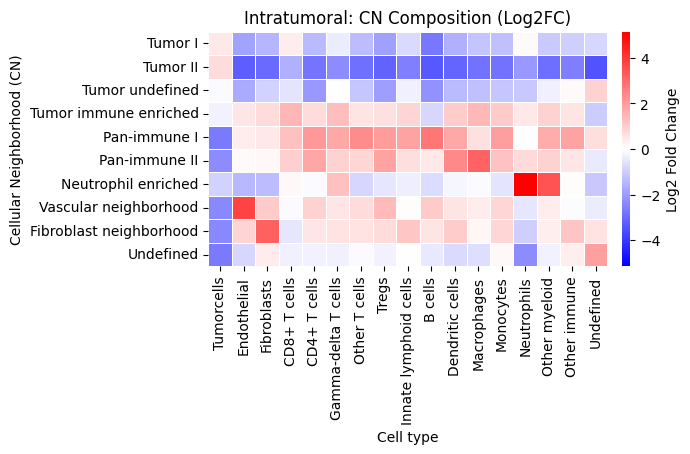

In [22]:
hm = plot_cn_heatmap(cluster_centers, 
                     "Intratumoral: CN Composition (Log2FC)",
                     unique_phenotypes=unique_phenotypes,
                     overall_phenotype_frequencies=global_cell_type_frequencies,
                     score_type='log2fc', 
                     annot=False,
                     figsize=(7,6),
                     annot_fontsize=10,
                     col_order=custom_cell_order,
                     cn_id_to_name_map=cn_id_to_name_mapping, 
                     final_row_order=final_display_order 
                    )

save_plot(hm, "CN_10_intratumoral_lFC", output_dir)

# Show plot in notebook
if is_notebook():
    display(hm)

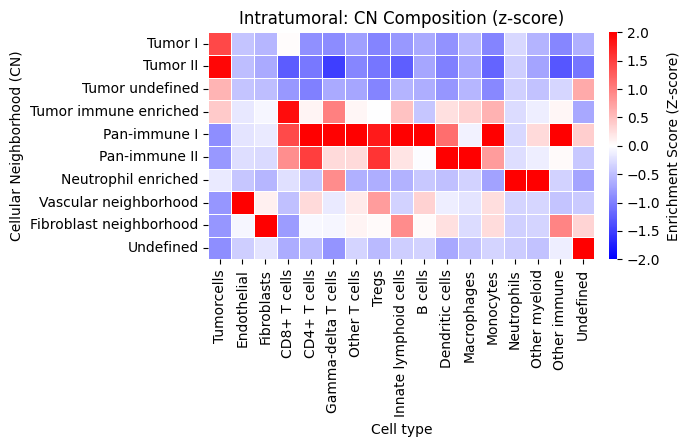

In [23]:
hm = plot_cn_heatmap(cluster_centers, 
                     "Intratumoral: CN Composition (z-score)", 
                     unique_phenotypes=unique_phenotypes,
                     overall_phenotype_frequencies=global_cell_type_frequencies,
                     score_type='z_score',
                     annot=False, 
                     figsize=(7,6),
                     annot_fontsize=10,
                     col_order=custom_cell_order,
                     min_max=(-2, 2),
                     cn_id_to_name_map=cn_id_to_name_mapping, 
                     final_row_order=final_display_order 
                    )

save_plot(hm, "CN_10_intratumoral_z-score", output_dir)

# Show plot in notebook
if is_notebook():
    display(hm)